In [1]:
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (669 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
%matplotlib inline

In [3]:
### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt install ghostscript python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 11 newly installed, 0 to remove and 37 not upgraded.
Need to get 14.1 MB of archives.
After this operation, 49.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-droid-fallback all 1:6.0.

# **CSE4022 - NLP Project**

**Naviyaa Poonia (19BCE1377)**

**Sujana Ray (19BCE1391)**


# **Project Title** : Application of Recurrent Neural Network in online comment toxicity detection and classification


# ***Exploratory Data Analysis***

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#importing the libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import seaborn as sns 
import missingno as msno
import re
import string
import nltk
from nltk.corpus import stopwords


In [6]:
train_df = pd.read_csv("/content/drive/MyDrive/CSE4022/dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CSE4022/dataset/test.csv")

In [7]:
train_df.shape

(159571, 8)

In [8]:
test_df.shape

(153164, 2)

In [9]:
train_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28459,4b596155fe3a094d,"""\nYou are mistaken. Ceoil """,0,0,0,0,0,0
121557,8a5c02a396f5b5cc,"""\n\nI do believe that pro se litigation is a ...",0,0,0,0,0,0
147551,3e1a03585a5c2429,"""::WP Vauxhall says the Russians were impresse...",0,0,0,0,0,0
156518,cf70f7aae8599f82,GTEL \n\nDo not come in the article only to sc...,0,0,0,0,0,0
76026,cb7ef1eacb45c1a1,""", 21 January 2014 (UTC)\nNo rush, I'd be glad...",0,0,0,0,0,0
45663,7a19399809cb657f,"""\n\nThis poorly written Wiki article attempts...",0,0,0,0,0,0
146924,33eb8f94ac160bed,""":::It is both uncivil and disruptive of you t...",0,0,0,0,0,0
721,01f2e4ae839719df,"""\n\nThe spelling """"Tacarimba La Tumba Del Fue...",0,0,0,0,0,0
124332,991a812888086121,You are biast liberals that is all there is to...,0,0,0,0,0,0
19066,3250a1edecb089e9,why can't you get yourself a girl? are you th...,0,0,0,0,1,0


In [10]:
nrow_train=train_df.shape[0]
nrow_test=test_df.shape[0]
sum=nrow_train+nrow_test
print("Rows")
print("train: ", nrow_train)
print("test: ", nrow_test)

Rows
train:  159571
test:  153164


###Class imbalance in train set

In [11]:
x=train_df.iloc[:,2:].sum()
#marking comments without any tags as "unlabelled"
rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['unlabelled']=(rowsums==0)
#count number of unlabelled entries
train_df['unlabelled'].sum()
print("Total comments:",len(train_df))
print("Total unlabelled comments:",train_df['unlabelled'].sum())
print("Total tags:",x.sum())

Total comments: 159571
Total unlabelled comments: 143346
Total tags: 35098


In [12]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###Missing values in train_df

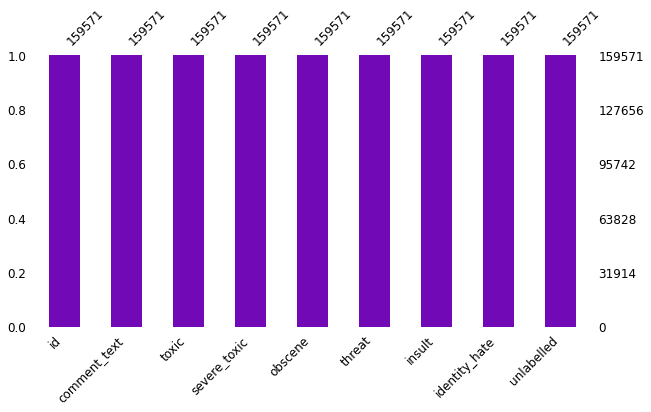

In [13]:
msno.bar(train_df,color='#7209b7', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

###Number of occurrences of the label types

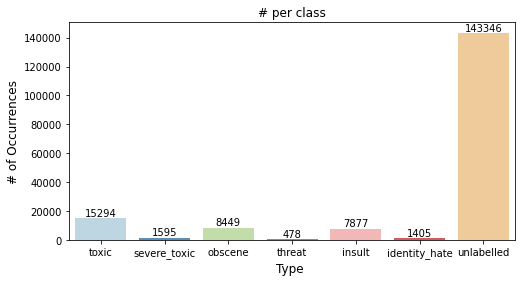

In [14]:
x=train_df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8, palette = "Paired")
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

###Testing data

In [15]:
test_df.sample(5)

,id,comment_text
56790,5e84835dc41de7ef,":I don't know, since today is the first time I..."
128448,d6b2fb3318b76b40,""" \n\n == and mexicans? also radio crap i hear..."
15531,1a1e28067e91a3b0,: Well tell your brother (and his online frien...
113687,bdc8e205ae9eeadf,""" I realized what silly-things I did: that's n..."
47128,4e2ccb60b0bebc34,Okay - - feeling a little bit stupid! p - - my...


###Missing values in test_df

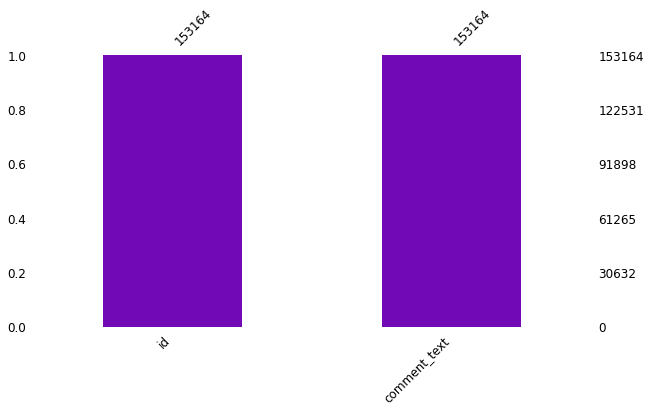

In [16]:
msno.bar(test_df,color='#7209b7', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

###Which tags/labels occur together the most

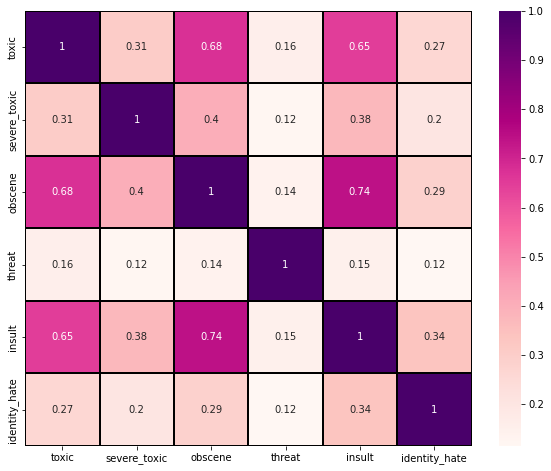

In [17]:
temp_df=train_df.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True,
            cmap='RdPu',
            linewidths=1,
            linecolor='black')

In [18]:
# let's see the total rows in train, test data and the numbers for the various categories
tags = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[tags].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


###Confusion matrix/CrossTab

In [19]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [20]:
#Crosstab
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

We can see that severely toxic comments are always toxic.

###**Example Comments**

In [21]:
print("toxic:")
print(train_df[train_df.severe_toxic==1].iloc[14,1])

toxic:
SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!


In [22]:
print("severe_toxic:")
print(train_df[train_df.severe_toxic==1].iloc[5,1])

severe_toxic:
"You know, I was thinking...

Nobody really attacked me before I revealed my age here.  After I announced that I was 14, I was subject to a constant storm of harassment and abuse.

The same thing goes for when I was on The Sandbox when I was 11.  Before people knew my age, they didn't care.  After I told them my age, they hated me.

It's just so amusing how the idiot Soapboxers think of teenagers as being responsible for the ""decline"" of The Soapbox (like it was ever any good to begin with).  This is funny, because the adults are the dumbest people here.  Mauricio, Chuppah, Redneckgirl, Pinky, Scooby, GG, ForeverLostTinkerbell, greenrabbit, StarRocketsInFlight, Bree-Robinson, enigma-72, CocaineNightmares, TokyoDome, Chad_Ocho-Cinco, Steve Lake...

...all adults.

The teenage posters here are typically the smartest ones.  Let's see... G-Dawg, Head_Banging_Brunette, ClassicAge, Metropolis (even though he's a bipolar weirdo), ChrisScript, just to name a few.

All I ever se

In [23]:
print("Threat:")
print(train_df[train_df.threat==1].iloc[2,1])

Threat:
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you


In [24]:
print("Obscene:")
print(train_df[train_df.obscene==1].iloc[4,1])

Obscene:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [25]:
print("identity_hate:")
print(train_df[train_df.identity_hate==1].iloc[5,1])

identity_hate:
Gay 

The existence of CDVF is further proof that  is a sad twat. He is also very ugly, and has a willy for a face.


# ***Feature Engineering***

###Indirect features

In [26]:
merge=pd.concat([train_df.iloc[:,0:2],test_df.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [27]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769


In [28]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

df.head(5)

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


In [29]:
#seperate train and test features
train_feats=df.iloc[0:len(train_df),]
test_feats=df.iloc[len(train_df):,]
#join the tags
train_tags=train_df.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

# ***Data Preparation***

In [30]:
# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split
#from sklearn.cross_validation import train_test_split

# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os
import re

sns.set_style("whitegrid")
np.random.seed(0)

!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import chart_studio
chart_studio.tools.set_credentials_file(username='n_p', api_key='••••••••••')


# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

     |████████████████████████████████| 64 kB 2.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Double check with Python 3


In [31]:
train_df = train_df.loc[(train_df['toxic'] == 1) | (train_df['severe_toxic'] == 1) | (train_df['obscene'] ==1) | (train_df['threat'] == 1) | (train_df['insult'] == 1) | (train_df['identity_hate'] ==1)]

train_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unlabelled
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,False
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,False
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,False
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,False


## Cleaning the Train dataset

In [32]:
#Removing punctuations
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in train_df['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

train_df['comment_text'] = totalContentCleaned

train_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unlabelled
128205,ada49191ec6f498e,Nitpicking\nIf someone is complaining about so...,1,0,0,0,0,0,False
117528,73ee076f8b003d51,What the fuck is wrong with you You say I am a...,1,0,1,0,1,0,False
125531,9f73d50326172b7d,screw you\ni do what i want,1,0,1,0,0,0,False
79596,d4f197244abaef7a,This culture allows people to hold their wives...,1,0,1,0,0,0,False
24341,40465e543368eaf4,a virgin Nighty night,1,0,0,0,0,0,False
68567,b77447267cd0403f,3 February 2009 UTC\n\nStupid Dont be a smart...,1,0,1,0,1,0,False
101137,1d557ed3732ae915,Holy shit you are really doing this You are fu...,1,0,1,0,1,0,False
10644,1c1d731daed64791,SHUT UP FAG \n\nLOL YOU WILL BAN ME HUH\nOOH I...,1,0,1,0,1,0,False
107808,403b8d45b0e42aa3,May God curse your soul for eternity \n\nAmen2...,1,0,0,0,0,0,False
9353,18d3dbfb90b571a5,Your hypocrisy amuses me \n\nLook at your user...,1,0,0,0,0,0,False


## Cleaning the Test dataset

In [33]:
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in test_df['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

test_df['comment_text'] = totalContentCleaned

test_df.sample(10)

,id,comment_text
32634,36438ed529098dea,open your blind eyes check what are 8640214213...
125654,d1e29553e514c738,\n\n \n Jefferson Airplane We Can Be Togethe...
116411,c244205d63b55a90,sea anemones are very weird creatures they poo...
143346,ef965756de9c2110,\n I often make mistakes but this isnt one of...
31398,3435d41f7cfe1f6c,\n\n Please stop creating useless pages such ...
89640,957f53b293b7415c,Affluent areas in Bromley \n\n I saw you rec...
87115,915baa90a43fec0f,Hello I have a Bolkow 207 and looking for som...
119412,c761ce299def28fd,rihanna the ugly \n\n i hate rihanna is is u...
129599,d88f64c948e07fb2,Destiny Wesy is Gay
37031,3d7c169faf5d2141,It was the use of the source I was attacking n...


### Test labels dataset

In [34]:
#Loading the test_labels.csv file
test_labels = pd.read_csv("/content/drive/MyDrive/CSE4022/dataset/test_labels.csv")
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [35]:
test_labels = test_labels[(test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


### Merging the test_labels and test_df dataset as one - test

In [36]:
test = pd.merge(test_labels, test_df, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding I think very highl...
1,000247e83dcc1211,0,0,0,0,0,0,Dear god this site is horrible
2,0002f87b16116a7f,0,0,0,0,0,0,Somebody will invariably try to add Religion ...
3,0003e1cccfd5a40a,0,0,0,0,0,0,\n\n It says it right there that it IS a type...
4,00059ace3e3e9a53,0,0,0,0,0,0,\n\n Before adding a new product to the list...
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,Reason for banning throwing \n\n This articl...
7,000844b52dee5f3f,0,0,0,0,0,0,blocked from editing Wikipedia
8,00091c35fa9d0465,1,0,0,0,0,0,Arabs are committing genocide in Iraq but no ...
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop If you continue to vandalize Wikip...


In [37]:
test = test.loc[(test['toxic'] == 1) | (test['severe_toxic'] == 1) | (test['obscene'] ==1) | (test['threat'] == 1) | (test['insult'] == 1) | (test['identity_hate'] ==1)]

test.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,00091c35fa9d0465,1,0,0,0,0,0,Arabs are committing genocide in Iraq but no ...
24,0013fed3aeae76b7,1,0,1,0,1,1,DJ Robinson is gay as hell he sucks his dick s...
29,0017d4d47894af05,1,0,1,0,1,0,Fuck off you antisemitic cunt
38,001d739c97bc2ae4,1,0,0,0,0,0,How dare you vandalize that page about the HMS...
40,001eff4007dbb65b,1,0,1,0,1,0,No he is an arrogant self serving immature idi...


## Records in the test and train dataset

In [38]:
print("Train:", train_df.shape)
print("Test:", test.shape)

Train: (16225, 9)
Test: (6243, 8)


In [39]:
# check for missing values
print('The train dataset has', train_df.isna().sum().sum(), 'missing values.')
print('The test dataset has', test.isna().sum().sum(), 'missing values.')

# check if there are any duplicates
print('The train dataset has', train_df.duplicated().sum(), 'duplicates.')
print('The test dataset has', test.duplicated().sum(), 'duplicates.')

The train dataset has 0 missing values.
The test dataset has 0 missing values.
The train dataset has 0 duplicates.
The test dataset has 0 duplicates.


# ***Data Preprocessing***

In [40]:
#Convert text to vectors using keras preprocessing library tools

X_train = train_df["comment_text"].values
X_testdf = test_df['comment_text'].values
X_test  = test["comment_text"].values

y_train = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [41]:
num_words = 20000 #Max. workds to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 15 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

In [42]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_testdf = tokenizer.texts_to_sequences(X_testdf) 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)
X_testdf  = sequence.pad_sequences(X_testdf,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print('X_testdf shape: ', X_testdf.shape)

X_train shape: (16225, 200)
X_test shape:  (6243, 200)
X_testdf shape:  (153164, 200)


In [43]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, train_size =0.9, random_state=233)

In [44]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

# ***Using the Word2Vec embedding***

In [45]:
#Importing the libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize, RegexpParser

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [46]:
from nltk.tree import Tree
from nltk.draw.tree import TreeView

### POS Tagging

In [47]:
toxicComments_lines = list()
lines = train_df['comment_text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)

    tagged = nltk.pos_tag(tokens)
    tagged[0:6]
    
#Extract all parts of speech from any text
    chunker = RegexpParser("""
					    NP: {<DT>?<JJ>*<NN>} #To extract Noun Phrases
					    P: {<IN>}			 #To extract Prepositions
					    V: {<V.*>}			 #To extract Verbs
					    PP: {<p> <NP>}		 #To extract Prepositional Phrases
					    VP: {<V> <NP|PP>*}	 #To extract Verb Phrases
					    """)
    [([s.lower() for s in item[0]], item[1]) for item in tagged]
# Print all parts of speech in above sentence
    output = chunker.parse(tagged)
    if(lines.index(line)==20):
        print("After Extracting\n", output)
        t = Tree.fromstring(str(output))
        TreeView(t)._cframe.print_to_file('output.ps')

    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

After Extracting
 (S
  you/PRP
  (VP (V are/VBP) (NP a/DT stupid/JJ fuck/NN))
  and/CC
  your/PRP$
  mothers/NNS
  (VP (V cunt/VBP))
  stinks/NNS)


16225

In [48]:
from PIL import Image

psimage=Image.open('output.ps')
psimage.save('Parsetree.png')

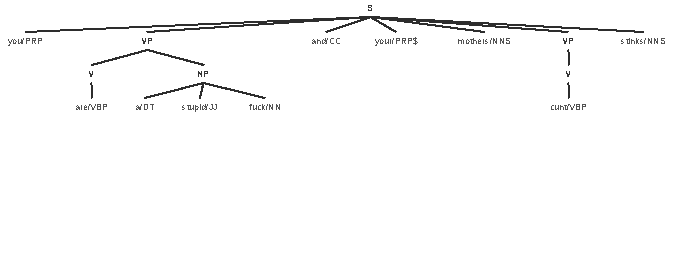

In [49]:
from cv2 import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("Parsetree.png", 0)
cv2_imshow(img)

#### Training the Word2Vec embedding

In [50]:
#train word2vec mode
embedding_dims = 128 #embedding vector output dimension 
max_len = 200 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences=toxicComments_lines, size= embedding_dims, window=5, workers=4, min_count=1)
#vocab size
wors = list(word2VecModel.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 25


#### Test Word2Vec Model

In [51]:
#Save the Word2Vec Corpus locally
filename = 'toxic_embedding_word2vec.txt'
word2VecModel.wv.save_word2vec_format(filename, binary=False)

### Use the Pre-Trained Embedding (Word2Vec) in our model


In [52]:
word2Vec_embeddings_index = {}
word2vec_file = open(os.path.join('', 'toxic_embedding_word2vec.txt'), encoding = "utf-8")

for line in word2vec_file:
    values = line.split()
    word = values[0]
    coefficient = np.asarray(values[1:])
    word2Vec_embeddings_index[word] = coefficient
word2vec_file.close()

#### Convert the word embedding into tokenized vector

In [53]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

toxicComments_pad = pad_sequences(sequences, maxlen=max_len)
comments_tag = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
print('Shape of toxic comments tensor', toxicComments_pad.shape)
print('Shape of comment tensor', comments_tag.shape)

Found 36870 uniquue tokens.
Shape of toxic comments tensor (16225, 200)
Shape of comment tensor (16225, 6)


###Create a matrix with of word vectors

In [54]:
num_words = len(word_index)+1
word2Vec_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i  in word_index.items():
    if i > num_words:
        continue
    word2Vec_embedding_vector = word2Vec_embeddings_index.get(word)
    if word2Vec_embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        word2Vec_embedding_matrix[i] = word2Vec_embedding_vector

print(num_words)
print(word2Vec_embedding_matrix.shape[0])
print(word2Vec_embedding_matrix.shape[1])

36871
36871
128


# ***Latent Semantic Analysis (LSA)***

In [55]:
from sklearn.decomposition import TruncatedSVD
lsa_obj = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
word2vec_lsa_data = lsa_obj.fit_transform(word2Vec_embedding_matrix)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T

## Visualising the singular values representing how much each latent concept explains the variance in the data

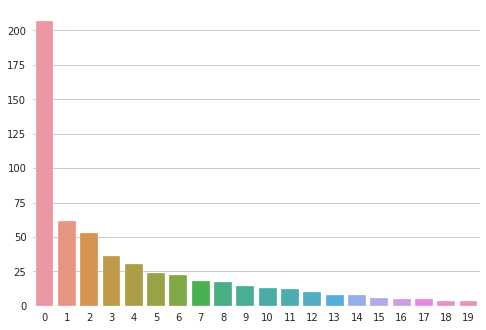

In [56]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [57]:
V_T.shape

(128, 20)

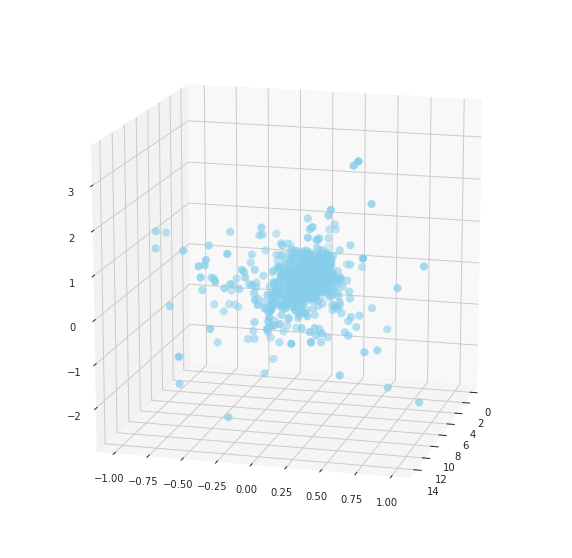

In [58]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word2vec_lsa_data[:,0], word2vec_lsa_data[:,15], word2vec_lsa_data[:,9], c='skyblue', s=60)
ax.view_init(15, 15)
plt.show()

#***Bidirecitional LSTM with Word2Vec***

## Using Precision, Recall, F1-Measure, etc. evaluation metrics to evaluate our model

In [59]:
#Import necessary libraries
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def precision(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [60]:
Bil_LSTM_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])


Bil_LSTM_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.01, decay = 0.01/32), metrics=['accuracy', mean_pred, fmeasure, precision, recall])

###Visualize the Orchestrated Bidirectional LSTM-Word2Vec Model Architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          4719488   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 128)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200, 50)          30800     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200, 50)          200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200, 50)           0         
                                                        

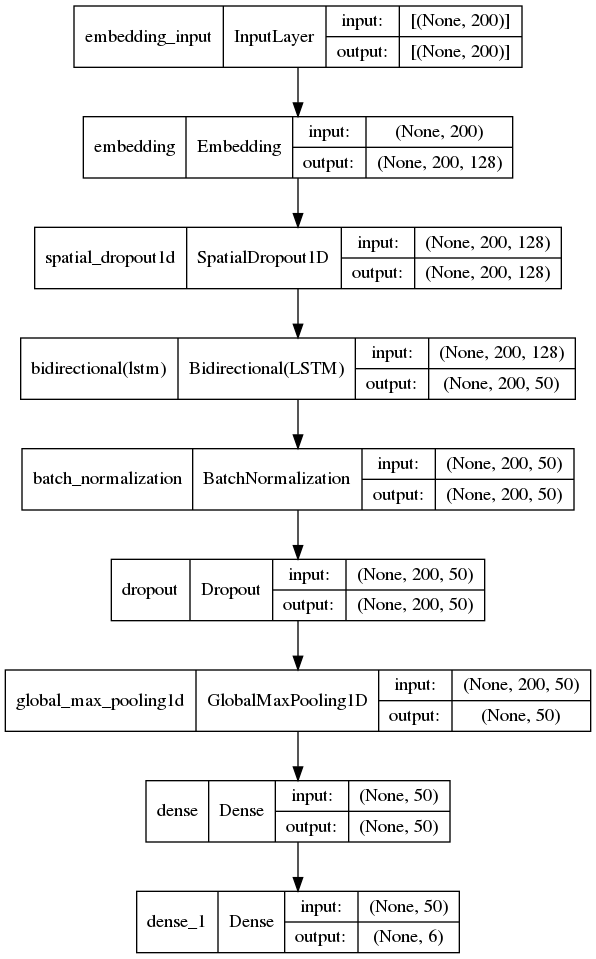

In [61]:
!pip install pillow
from PIL import Image

Bil_LSTM_Word2Vec_model.summary()

plot_model(Bil_LSTM_Word2Vec_model, to_file='Bil_LSTM_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
#Image(retina=True, filename='Bil_LSTM_Word2Vec_model_plot.png')

###Fit the model on the dataset

In [62]:
Bil_LSTM_Word2Vec_model_fit = Bil_LSTM_Word2Vec_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val))

Epoch 1/15
58/58 [==============================] - 33s 489ms/step - loss: 0.4518 - accuracy: 0.9223 - mean_pred: 0.3669 - fmeasure: 0.6907 - precision: 0.7411 - recall: 0.6670 - val_loss: 0.5552 - val_accuracy: 0.9464 - val_mean_pred: 0.4594 - val_fmeasure: 0.7606 - val_precision: 0.6608 - val_recall: 0.8971
Epoch 2/15
58/58 [==============================] - 27s 469ms/step - loss: 0.3836 - accuracy: 0.9421 - mean_pred: 0.3594 - fmeasure: 0.7206 - precision: 0.7837 - recall: 0.6741 - val_loss: 0.5231 - val_accuracy: 0.9470 - val_mean_pred: 0.4476 - val_fmeasure: 0.7402 - val_precision: 0.7968 - val_recall: 0.6913
Epoch 3/15
58/58 [==============================] - 27s 468ms/step - loss: 0.3783 - accuracy: 0.9421 - mean_pred: 0.3599 - fmeasure: 0.7249 - precision: 0.8003 - recall: 0.6761 - val_loss: 0.5107 - val_accuracy: 0.9347 - val_mean_pred: 0.4594 - val_fmeasure: 0.7616 - val_precision: 0.6611 - val_recall: 0.8993
Epoch 4/15
58/58 [==============================] - 27s 471ms/step 

###Evaluate the BiLSTM+Word2Vec train and test score

In [63]:
#train
Bil_LSTM_Word2Vec_train_score = Bil_LSTM_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', Bil_LSTM_Word2Vec_train_score[0])
print('Train Accuracy:', Bil_LSTM_Word2Vec_train_score[1])

#test
Bil_LSTM_Word2Vec_test_score = Bil_LSTM_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', Bil_LSTM_Word2Vec_test_score[0])
print('Test Accuracy:', Bil_LSTM_Word2Vec_test_score[1])

64/64 [==============================] - 11s 174ms/step - loss: 0.4009 - accuracy: 0.9407 - mean_pred: 0.4227 - fmeasure: 0.7787 - precision: 0.8475 - recall: 0.7205
Train Loss: 0.40090638399124146
Train Accuracy: 0.9407087564468384
25/25 [==============================] - 4s 172ms/step - loss: 0.4050 - accuracy: 0.9742 - mean_pred: 0.4260 - fmeasure: 0.7665 - precision: 0.8548 - recall: 0.6951
Test Loss: 0.40503570437431335
Test Accuracy: 0.9742110967636108


###Plot Training & Validation Accuracy with the Loss values of the BiLSTM-Word2Vec Model

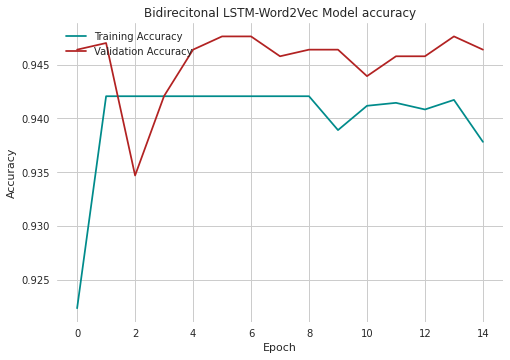

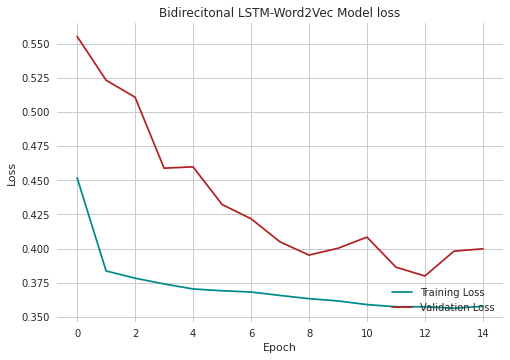

In [64]:
# Plot training & validation accuracy values
plt.plot(Bil_LSTM_Word2Vec_model_fit.history['accuracy'],  color="DarkCyan")
plt.plot(Bil_LSTM_Word2Vec_model_fit.history['val_accuracy'], color="FireBrick")
plt.title('Bidirecitonal LSTM-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Bil_LSTM_Word2Vec_model_fit.history['loss'], color="DarkCyan")
plt.plot(Bil_LSTM_Word2Vec_model_fit.history['val_loss'], color="FireBrick")
plt.title('Bidirecitonal LSTM-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [65]:
# concat all training, validation and testing accuracy scores

Bidirectional_LSTM_Word2Vec_Accuracy = ['Bidirectional LSTM with Word2Vec', 
                    np.max(Bil_LSTM_Word2Vec_model_fit.history['accuracy']), 
                    np.max(Bil_LSTM_Word2Vec_model_fit.history['val_accuracy']), 
                    Bil_LSTM_Word2Vec_test_score[1]]


# create dataframe
experimentalResult = pd.DataFrame([Bidirectional_LSTM_Word2Vec_Accuracy])

# beautify the new dataframe
experimentalResult.columns = ['Model', 'Training', 'Validation', 'Testing']
experimentalResult.set_index(['Model'], inplace=True)
experimentalResult.to_csv("BiLSTM_scores.csv", index = False)

print(experimentalResult)

                                  Training  Validation   Testing
Model                                                           
Bidirectional LSTM with Word2Vec  0.942063    0.947628  0.974211


# Evaluation of Experiment With Word2Vec Pre-trained Embedding

## Computing the highest of the evaluation matrics 

In [66]:
trace = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#ffa07a'),
                align = ['left'] * 5),
    cells=dict(values=[[' Bidirectional LSTM with word2Vec'],
                       [
                        #Loss Evaluation
                        round(np.max(Bil_LSTM_Word2Vec_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.max(Bil_LSTM_Word2Vec_model_fit.history['accuracy']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.max(Bil_LSTM_Word2Vec_model_fit.history['mean_pred']), 3)],
						
                        #F1-Measure Evaluation fmeasure
                        [round(np.max(Bil_LSTM_Word2Vec_model_fit.history['fmeasure']), 3)],
						             
                        #Precision Evaluation precision
                        [round(np.max(Bil_LSTM_Word2Vec_model_fit.history['precision']), 3)],                      
                       
                       ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#ffcd8a'),
               align = ['left'] * 5))])

trace.show()

## Computing the mean average of the evaluation matrics

In [67]:
trace = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#ffa07a'),
                align = ['left'] * 5),
    cells=dict(values=[[' Bidirectional LSTM with Word2Vec'],
                       [
                        #Loss Evaluation
                        round(np.mean(Bil_LSTM_Word2Vec_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.mean(Bil_LSTM_Word2Vec_model_fit.history['loss']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.mean(Bil_LSTM_Word2Vec_model_fit.history['mean_pred']), 3)],
						
                        #F1-Measure Evaluation fmeasure
                        [round(np.mean(Bil_LSTM_Word2Vec_model_fit.history['fmeasure']), 3)],
						             
                        #Precision Evaluation precision
                        [round(np.mean(Bil_LSTM_Word2Vec_model_fit.history['precision']), 3)],
                                              ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#ffcd8a'),
               align = ['left'] * 5))])

trace.show()

##Making predictions on the test data


In [68]:
#list all the output class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#make the predictions
y_pred = Bil_LSTM_Word2Vec_model.predict(X_testdf, verbose = 1, batch_size = batch_size2)

599/599 [==============================] - 106s 175ms/step


In [69]:
#making submission
#read in the submission file
output = pd.read_csv("/content/drive/MyDrive/CSE4022/dataset/output.csv")

output[list_classes] = y_pred
output.to_csv("BiLSTM_output.csv", index = False)


In [70]:
output_df = pd.read_csv("/content/drive/MyDrive/CSE4022/dataset/BiLSTM_output.csv")
output_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.824650,0.197494,0.600668,0.135870,0.528659,0.233360
1,0000247867823ef7,0.840179,0.109303,0.429206,0.081028,0.423650,0.156579
2,00013b17ad220c46,0.904574,0.195712,0.537663,0.087423,0.508086,0.199340
3,00017563c3f7919a,0.863953,0.112309,0.436514,0.105043,0.476081,0.160860
4,00017695ad8997eb,0.867412,0.173252,0.494663,0.099759,0.485690,0.202344


## Chi-Square Test on dependency of labels on each other in the predicted outputs

In [71]:
output_df=output_df.iloc[:,1:]
output_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.824650,0.197494,0.600668,0.135870,0.528659,0.233360
1,0.840179,0.109303,0.429206,0.081028,0.423650,0.156579
2,0.904574,0.195712,0.537663,0.087423,0.508086,0.199340
3,0.863953,0.112309,0.436514,0.105043,0.476081,0.160860
4,0.867412,0.173252,0.494663,0.099759,0.485690,0.202344
...,...,...,...,...,...,...
153159,0.872762,0.163757,0.477082,0.093178,0.470400,0.185538
153160,0.840065,0.104469,0.433267,0.105720,0.441961,0.161243
153161,0.822837,0.088004,0.422398,0.078593,0.411640,0.155510
153162,0.781066,0.087871,0.427468,0.093733,0.420437,0.181701


In [72]:
for i in output_df.columns:
  output_df[i] = (output_df[i] > 0.5).astype(int)

output_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,1,0,1,0
1,1,0,0,0,0,0
2,1,0,1,0,1,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [73]:
#Crosstab
main_col="toxic"
corr_mats=[]
for other_col in output_df.columns:
    confusion_matrix = pd.crosstab(output_df[main_col], output_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=output_df.columns)
out1=pd.concat(corr_mats,axis=1,keys=output_df.columns)
#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [74]:

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(out1)
print(stat,p,dof,expected) 
# interpret p-value
alpha = 0.05
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

0.0 1.0 0 [[153164. 152563.    601. 125050.  28114. 153164. 125058.  28106. 153164.]]
Independent (H0 holds true)


In [75]:
#Crosstab
main_col="obscene"
corr_mats=[]
for other_col in output_df.columns:
    confusion_matrix = pd.crosstab(output_df[main_col], output_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=output_df.columns)
out2=pd.concat(corr_mats,axis=1,keys=output_df.columns)
#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [76]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(out2)
print(stat,p,dof,expected) 
# interpret p-value
alpha = 0.05
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

248314.0111194391 0.0 8 [[1.25050000e+05 1.24559316e+05 4.90683516e+02 1.02096462e+05
  2.29535380e+04 1.25050000e+05 1.02102994e+05 2.29470065e+04
  1.25050000e+05]
 [2.81140000e+04 2.80036835e+04 1.10316484e+02 2.29535380e+04
  5.16046196e+03 2.81140000e+04 2.29550065e+04 5.15899352e+03
  2.81140000e+04]]
Dependent (reject H0)
